# caustiques (2020) / iridiscence (2022)

* This repository *https://github.com/NaturalPatterns/2020_caustiques* presents 2 succesive projects
  1. One where I developped a modelling of caustics produced by shallow water and which are detailed in https://laurentperrinet.github.io/sciblog/posts/2020-06-19-caustic-optics.html
  2. Another, where I build upon that work to decompose the spectrum of light into its different wavelength, producing *iridescent caustics*.
 * Rendering of the [full notebook](https://naturalpatterns.github.io/2020_caustiques/) in which I explore the role of different parameters in prouding the images.

## caustiques (2020)

[![DOI](https://zenodo.org/badge/273226625.svg)](https://zenodo.org/badge/latestdoi/273226625)

Caustics ([wikipedia](https://en.wikipedia.org/wiki/Caustic_(optics))) are luminous patterns which are resulting from the superposition of smoothly deviated light rays. It is the heart-shaped pattern in your cup of coffee which is formed as the rays of from the sun are reflected on the cup's surface. It is also the wiggly patterns of light that you will see on the floor of a pool as the sun's light is *refracted* at the surface of the water. Here we will simulate this particular physical phenomenon. Simply because they are mesmerizingly beautiful, but also as it is of interest in visual neuroscience. Indeed, it speaks to how images are formed (more on this later), hence how the brain may understand images.

In [this post](https://laurentperrinet.github.io/sciblog/posts/2020-06-19-caustic-optics.html), I have developed a simple formalism to generate such patterns, with the paradoxical result that it is *very* simple to code yet generates patterns with great complexity, such as:

<BR>
<center>
<img src="caustique.gif" width="100%"/>
</center>
<BR>

This is joint work with artist [Etienne Rey](https://laurentperrinet.github.io/authors/etienne-rey/), in which I especially follow the ideas put forward in the series [Turbulence](http://ondesparalleles.org/projets/turbulences/).

## iridiscence (2022)

Upon further observation, one may discover that caustics exhibit some [iridescence](https://en.wikipedia.org/wiki/Iridescence)$^\ddagger$, that is, that the light pattern which forms the waggling lines of the caustics may decompose into different colors, forming evanescent rainbows. Here, we will simply use a modulation of the [Snell-Descartes law](https://en.wikipedia.org/wiki/Snell's_law) that we used to compute different angle of refraction. This will be put in relation with the dependance of the refraction index with the wavelength of light and the transformation of a [monochromatic light into RGB](https://github.com/laurentperrinet/lambda2color) that we used in a previous post about [colors of the sky](https://laurentperrinet.github.io/sciblog/posts/2020-07-04-colors-of-the-sky.html). The results are close to subjective observations, with the surprising (to me) observation that colors appear more *between* nodes...
  
<BR>
<center>
<video src="iridiscence.mp4" width="100%"/>
</center>
<BR>

Note: $\ddagger$ I use the term iridescence which is improper in the physical sense as it rather concerns the property of an object to exhibit different colors depending on the angle of view. However, in the perspective of the work with [Etienne Rey](https://laurentperrinet.github.io/authors/etienne-rey/) it resonates with our endeavour to show that percepetion, in particular visual perception, is an active process of the observer within its environment.


# source code

## defining the parameters

In [1]:
figpath = '2022-09-02_caustique'

In [2]:
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt

In [3]:
PRECISION = 4

In [4]:
PRECISION = 7

In [5]:
import os
import datetime
import numpy as np

def init(args=[], figpath=figpath, PRECISION=PRECISION):

    import argparse
    if figpath is None:
        import datetime
        date = datetime.datetime.now().date().isoformat()
        figpath = f'{date}_caustique'

    parser = argparse.ArgumentParser()
    parser.add_argument("--tag", type=str, default='caustique', help="Tag")
    parser.add_argument("--figpath", type=str, default=figpath, help="Folder to store images")
    parser.add_argument("--vext", type=str, default='mp4', help="Folder to store images")
    parser.add_argument("--nx", type=int, default=8*2**PRECISION, help="number of pixels (vertical)")
    parser.add_argument("--ny", type=int, default=8*2**PRECISION, help="number of pixels (horizontal)")
    parser.add_argument("--nframe", type=int, default=3*2**PRECISION, help="number of frames")
    parser.add_argument("--bin_dens", type=int, default=2, help="relative bin density")
    parser.add_argument("--bin_spectrum", type=int, default=8, help="bin spacing in spectrum")
    parser.add_argument("--seed", type=int, default=42, help="seed for RNG")
    parser.add_argument("--H", type=float, default=6., help="depth of the pool")
    parser.add_argument("--variation", type=float, default=.4, help="variation of diffraction index: http://www.philiplaven.com/p20.html 1.40 at 400 nm and 1.37 at 700nm makes a 2% variation")
    parser.add_argument("--scale", type=float, default=150, help="sf")
    parser.add_argument("--B_sf", type=float, default=0.25, help="bandwidth in sf")
    parser.add_argument("--V_Y", type=float, default=0.3, help="horizontal speed")
    parser.add_argument("--V_X", type=float, default=0.3, help="vertical speed")
    parser.add_argument("--B_V", type=float, default=1.0, help="bandwidth in speed")
    parser.add_argument("--theta", type=float, default=2*np.pi*(2-1.61803), help="angle with the horizontal")
    parser.add_argument("--B_theta", type=float, default=np.pi/3, help="bandwidth in theta")
    parser.add_argument("--min_lum", type=float, default=.2, help="diffusion level for the rendering")
    parser.add_argument("--gamma", type=float, default=2.8, help="Gamma exponant to convert luminosity to luminance")
    parser.add_argument("--fps", type=float, default=18, help="frames per second")
    parser.add_argument("--multispectral", type=bool, default=True, help="Compute caustics on the full spectrogram.")
    parser.add_argument("--cache", type=bool, default=True, help="Cache intermediate output.")
    parser.add_argument("--verbose", type=bool, default=False, help="Displays more verbose output.")

    opt = parser.parse_args(args=args)

    if opt.verbose:
        print(opt)
    return opt


In [6]:
print(f'Saving our simulations in={figpath}')

Saving our simulations in=2022-09-02_caustique


In [7]:
opt = init()
opt.figpath = figpath

In [8]:
opt

Namespace(tag='caustique', figpath='2022-09-02_caustique', vext='mp4', nx=1024, ny=1024, nframe=384, bin_dens=2, bin_spectrum=8, seed=42, H=6.0, variation=0.4, scale=150, B_sf=0.25, V_Y=0.3, V_X=0.3, B_V=1.0, theta=2.399988291783386, B_theta=1.0471975511965976, min_lum=0.2, gamma=2.8, fps=18, multispectral=True, cache=True, verbose=False)

## utilities

Transfoming a sequence of PNG frames into gif or mp4:

In [9]:
def make_gif(gifname, fnames, fps, do_delete=True):
    import imageio

    with imageio.get_writer(gifname, mode='I', fps=fps) as writer:
        for fname in fnames:
            writer.append_data(imageio.imread(fname))

    from pygifsicle import optimize
    optimize(str(gifname))
    if do_delete: 
        for fname in fnames: os.remove(fname)
    return gifname

# https://moviepy.readthedocs.io/en/latest/getting_started/videoclips.html#imagesequenceclip
def make_mp4(mp4name, fnames, fps, do_delete=True):
    import moviepy.editor as mpy
    clip = mpy.ImageSequenceClip(fnames, fps=fps)
    clip.write_videofile(mp4name, fps=fps, codec='libx264', verbose=False, logger=None)
    if do_delete: 
        for fname in fnames: os.remove(fname)
    return mp4name


Utilities to compute the spectrum of the blue sky and convert them later to RGB values (check out https://laurentperrinet.github.io/sciblog/posts/2020-07-04-colors-of-the-sky.html for details)

In [10]:
from lambda2color import Lambda2color, xyz_from_xy

# borrowed from https://github.com/gummiks/gummiks.github.io/blob/master/scripts/astro/planck.py
def planck(wav, T):
    import scipy.constants as const
    c = const.c # c = 3.0e+8
    h = const.h # h = 6.626e-34
    k = const.k # k = 1.38e-23
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a / ( (wav**5) * (np.exp(b) - 1.0) )
    return intensity

def scattering(wav, a=0.005, p=1.3, b=0.45):
    """
    b is  proportionate  to  the  column  density  of  aerosols
    along  the  path  of  sunlight,  from  outside  the  atmosphere
    to  the  point  of  observation
    
    see https://laurentperrinet.github.io/sciblog/posts/2020-07-04-colors-of-the-sky.html for more details

    """
    # converting wav in µm:
    intensity = np.exp(-a/((wav/1e-6)**4)) # Rayleigh extinction by nitrogen
    intensity *= (wav/1e-6)**-4
    intensity *= np.exp(-b/((wav/1e-6)**p)) # Aerosols
    return intensity

## computing the caustics

In [11]:
from tqdm.notebook import tqdm, trange
import MotionClouds as mc
class Caustique:
    def __init__(self, opt):
        """
        Image coordinates follow 'ij' indexing, that is,
        * their origin at the top left,
        * the X axis is vertical and goes "down",
        * the Y axis is horizontal and goes "right".

        """
        self.mc = mc
        self.ratio = opt.ny/opt.nx # ratio between height and width (>1 for portrait, <1 for landscape)
        X = np.linspace(0, 1, opt.nx, endpoint=False) # vertical
        Y = np.linspace(0, self.ratio, opt.ny, endpoint=False) # horizontal
        self.xv, self.yv = np.meshgrid(X, Y, indexing='ij')
        self.opt = opt
        # https://stackoverflow.com/questions/16878315/what-is-the-right-way-to-treat-python-argparse-namespace-as-a-dictionary
        self.d = vars(opt)
        print(self.opt.figpath)
        os.makedirs(self.opt.figpath, exist_ok=True)
        self.cachepath = os.path.join('/tmp', self.opt.figpath)
        if opt.verbose: print(f'{self.cachepath=}')
        os.makedirs(self.cachepath, exist_ok=True)

        # a standard white:
        illuminant_D65 = xyz_from_xy(0.3127, 0.3291), 
        illuminant_sun = xyz_from_xy(0.325998, 0.335354)
        # color conversion class
        self.cs_srgb = Lambda2color(red=xyz_from_xy(0.64, 0.33),
                               green=xyz_from_xy(0.30, 0.60),
                               blue=xyz_from_xy(0.15, 0.06),
                               white=illuminant_sun)
        self.wavelengths = self.cs_srgb.cmf[:, 0]*1e-9
        self.N_wavelengths = len(self.wavelengths)
        # multiply by the spectrum of the sky
        intensity5800 = planck(self.wavelengths, 5800.)
        scatter = scattering(self.wavelengths)
        self.spectrum_sky = intensity5800 * scatter
        self.spectrum_sky /= self.spectrum_sky.max()



    def wave(self):
        filename = f'{self.cachepath}/{self.opt.tag}_wave.npy'
        if os.path.isfile(filename):
            z = np.load(filename)
        else:
            # A simplistic model of a wave using https://github.com/NeuralEnsemble/MotionClouds
            fx, fy, ft = mc.get_grids(self.opt.nx, self.opt.ny, self.opt.nframe)
            env = mc.envelope_gabor(fx, fy, ft, V_X=self.opt.V_Y, V_Y=self.opt.V_X, B_V=self.opt.B_V,
                                    sf_0=1./self.opt.scale, B_sf=self.opt.B_sf/self.opt.scale,
                                    theta=self.opt.theta, B_theta=self.opt.B_theta)
            z = mc.rectif(mc.random_cloud(env, seed=self.opt.seed))
            if self.opt.cache: np.save(filename, z)
        return z

    def transform(self, z_, modulation=1.):
        xv, yv = self.xv.copy(), self.yv.copy()

        dzdx = z_ - np.roll(z_, 1, axis=0)
        dzdy = z_ - np.roll(z_, 1, axis=1)
        xv = xv + modulation * self.opt.H * dzdx
        yv = yv + modulation * self.opt.H * dzdy

        xv = np.mod(xv, 1)
        yv = np.mod(yv, self.ratio)

        return xv, yv

    def plot(self, z, do_color=True, videoname=None, dpi=50):
        #hist = self.do_raytracing(z)
        binsx, binsy = self.opt.nx//self.opt.bin_dens, self.opt.ny//self.opt.bin_dens

        if videoname is None:
            videoname=f'{self.opt.figpath}/{self.opt.tag}.{self.opt.vext}'

        subplotpars = matplotlib.figure.SubplotParams(left=0., right=1., bottom=0., top=1., wspace=0., hspace=0.,)

        if self.opt.multispectral:

            #image_rgb = self.cs_srgb.spec_to_rgb(hist)
            image_rgb = np.zeros((self.opt.nx//self.opt.bin_dens,  self.opt.ny//self.opt.bin_dens, 3, self.opt.nframe))
            for i_frame in tqdm(range(self.opt.nframe)):
                for ii_wavelength, i_wavelength in enumerate(range(self.opt.bin_spectrum//2, self.N_wavelengths, self.opt.bin_spectrum)):
                    modulation = 1. + self.opt.variation/2 - self.opt.variation*i_wavelength/self.N_wavelengths
                    # print(i_wavelength, N_wavelengths, modulation)
                    xv, yv = self.transform(z[:, :, i_frame], modulation=modulation)
                    hist_, edge_x, edge_y = np.histogram2d(xv.ravel(), yv.ravel(),
                                                           bins=[binsx, binsy],
                                                           range=[[0, 1], [0, self.ratio]],
                                                           density=True)

                    spec = np.zeros((self.N_wavelengths))
                    spec[i_wavelength] = self.spectrum_sky[i_wavelength]
                    rgb = self.cs_srgb.spec_to_rgb(spec)

                    image_rgb[:, :, :, i_frame] += hist_[:, :, None] * rgb[None, None, :]

            # image_rgb -= image_rgb.min()
            image_rgb /= image_rgb.max()
        else:
            hist = np.zeros((binsx, binsy, self.opt.nframe))
            for i_frame in trange(self.opt.nframe):
                xv, yv = self.transform(z[:, :, i_frame])
                hist_, edge_x, edge_y = np.histogram2d(xv.ravel(), yv.ravel(),
                                                       bins=[binsx, binsy],
                                                       range=[[0, 1], [0, self.ratio]],
                                                       density=True)
            #hist /= hist.max()

        fnames = []
        for i_frame in range(self.opt.nframe):
            fig, ax = plt.subplots(figsize=(self.opt.ny/self.opt.bin_dens/dpi, self.opt.nx/self.opt.bin_dens/dpi), subplotpars=subplotpars)
            if self.opt.multispectral:
                ax.imshow(image_rgb[:, :, :, i_frame] ** (1/self.opt.gamma), vmin=0, vmax=1)
            else:
                if do_color:
                    bluesky = np.array([0.268375, 0.283377]) # xyz
                    sun = np.array([0.325998, 0.335354]) # xyz
                    # ax.pcolormesh(edge_y, edge_x, hist[:, :, i_frame], vmin=0, vmax=1, cmap=plt.cm.Blues_r)
                    # https://en.wikipedia.org/wiki/CIE_1931_color_space#Mixing_colors_specified_with_the_CIE_xy_chromaticity_diagram
                    L1 = 1 - hist[:, :, i_frame]
                    L2 = hist[:, :, i_frame]
                    image_denom = L1 / bluesky[1] + L2 / sun[1]
                    image_x = (L1 * bluesky[0] / bluesky[1] + L2 * sun[0] / sun[1]) / image_denom
                    image_y = (L1 + L2) / image_denom 
                    image_xyz = np.dstack((image_x, image_y, 1 - image_x - image_y))
                    image_rgb = self.cs_srgb.xyz_to_rgb(image_xyz)
                    image_L = self.opt.min_lum + (1-self.opt.min_lum)* L2 ** .61803
                    ax.imshow(image_L[:, :, None]*image_rgb, vmin=0, vmax=1)

                else:
                    ax.imshow(1-image_L, vmin=0, vmax=1)

            fname = f'{self.cachepath}/{self.opt.tag}_frame_{i_frame:04d}.png'
            fig.savefig(fname, dpi=dpi)
            fnames.append(fname)
            plt.close('all')
        if self.opt.vext == 'gif':
            return make_gif(videoname, fnames, fps=self.opt.fps)
        else:
            return make_mp4(videoname, fnames, fps=self.opt.fps)

    def show(self, videoname, width=1024):
        if self.opt.vext == 'gif':
            from IPython.display import Image, display
            return display(Image(url=videoname, width=width))
        else:
            #import moviepy.editor as mpy
            #return mpy.ipython_display(videoname, width=width)
            # https://github.com/NeuralEnsemble/MotionClouds/blob/master/MotionClouds/MotionClouds.py#L858
            from IPython.display import HTML, display
            opts = ' loop="1" autoplay="1" controls '
            html = HTML(f'<video {opts} src="{videoname}" type="video/{self.opt.vext}" width={width}\>')
            html.reload()
            return display(html)

# a simple caustics

## a wave pattern

In [12]:
c = Caustique(opt)
wave_videoname = f'{opt.figpath}/{opt.tag}_wave'
if not os.path.isfile(f'{wave_videoname}{c.mc.vext}'):
    print(f'Doing {wave_videoname}{c.mc.vext}')
    z = c.wave()
    c.mc.anim_save(z.swapaxes(0, 1), wave_videoname)
c.show(f'{wave_videoname}{c.mc.vext}')

2022-09-02_caustique


## generating the caustics

In [13]:
c = Caustique(opt)
z = c.wave()
z.shape

2022-09-02_caustique


(1024, 1024, 384)

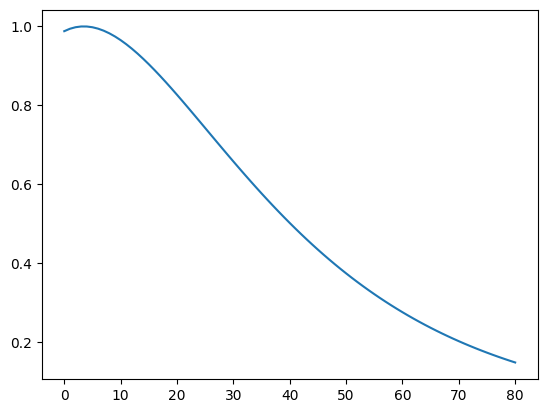

In [14]:
plt.plot(c.spectrum_sky)

0.999940278455398
0.9436145979945159
0.8269317618636288
0.6915618974366673
0.5614134738018063
0.44732398406761287
0.3524041700940417
0.2758710493991964
0.21533253512577508
0.1679921599369893


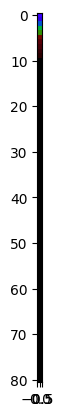

In [15]:
rgb = np.zeros((c.N_wavelengths, 1, 3))
for ii_wavelength, i_wavelength in enumerate(range(c.opt.bin_spectrum//2, c.N_wavelengths, c.opt.bin_spectrum)):
    #print(ii_wavelength, i_wavelength)

    spec = np.zeros((c.N_wavelengths))
    spec[i_wavelength] = 1
    rgb[ii_wavelength, 0, :] = c.cs_srgb.spec_to_rgb(spec) * c.spectrum_sky[i_wavelength]
    print(rgb[ii_wavelength, 0, :].max())
    
plt.imshow(rgb)

In [16]:
videoname = f'{opt.figpath}/{opt.tag}.{opt.vext}'
if not os.path.isfile(videoname):
    c = Caustique(opt)
    z = c.wave()
    videoname = c.plot(z)

In [17]:
c.show(videoname)

# exploring parameters

In [18]:
N_scan = 9
base = 2

## water depth

In [19]:
opt = init()
opt.figpath = figpath

c = Caustique(opt)
# compute just once
z = c.wave()

for H_ in c.opt.H*np.logspace(-1, 1, N_scan, base=base):
    opt = init()
    opt.figpath = figpath
    c = Caustique(opt)

    print(f'H = {H_:.3f}')
    c.opt.H = H_
    c.opt.tag = f'{opt.tag}_H_{H_:.3f}'
    videoname = f'{opt.figpath}/{c.opt.tag}.{opt.vext}'
    if not os.path.isfile(videoname):
        url=c.plot(z, videoname=videoname)
    c.show(videoname)

2022-09-02_caustique
2022-09-02_caustique
H = 3.000


2022-09-02_caustique
H = 3.568


2022-09-02_caustique
H = 4.243


2022-09-02_caustique
H = 5.045


2022-09-02_caustique
H = 6.000


2022-09-02_caustique
H = 7.135


2022-09-02_caustique
H = 8.485


2022-09-02_caustique
H = 10.091


2022-09-02_caustique
H = 12.000


## refraction index variation

In [20]:
opt = init()
opt.figpath = figpath

c = Caustique(opt)
z = c.wave()

for variation_ in np.logspace(-2, 0, N_scan, base=10, endpoint=False):
    opt = init()
    opt.figpath = figpath
    c = Caustique(opt)
    print(f'variation = {variation_:.3f}')
    c.opt.variation = variation_
    c.opt.tag = f'{opt.tag}_variation_{variation_:.3f}'
    videoname = f'{opt.figpath}/{c.opt.tag}.{opt.vext}'
    if not os.path.isfile(videoname):
        url=c.plot(z, videoname=videoname)
    c.show(videoname)

2022-09-02_caustique
2022-09-02_caustique
variation = 0.010


2022-09-02_caustique
variation = 0.017


2022-09-02_caustique
variation = 0.028


2022-09-02_caustique
variation = 0.046


2022-09-02_caustique
variation = 0.077


2022-09-02_caustique
variation = 0.129


2022-09-02_caustique
variation = 0.215


2022-09-02_caustique
variation = 0.359


2022-09-02_caustique
variation = 0.599


## other variables

In [21]:
for variable in ['scale', 'B_sf', 'B_theta', 'V_X', 'B_V', 'gamma', ]: #  'theta', 'V_Y'
    print(f'======{variable}======')
    for modul in np.logspace(-1, 1, N_scan, base=base):
        opt = init()
        opt.figpath = figpath

        c = Caustique(opt)
        c.d[variable] *= modul
        c.opt.tag = f'{opt.tag}_{variable}_modul_{modul:.3f}'
        videoname = f'{opt.figpath}/{c.opt.tag}.{opt.vext}'

        print(f'{variable}={variable}(default)*{modul:.3f}={c.d[variable]:.3E}')
        if not os.path.isfile(videoname):
            print('Doing ', videoname)
            z = c.wave()
            mcname = f'{opt.figpath}/{c.opt.tag}'
            if False: #not os.path.isfile(f'{mcname}{c.mc.vext}'): 
                print('Doing ', f'{mcname}{c.mc.vext}')
                c.mc.anim_save(z.swapaxes(0, 1), f'{mcname}')
            url=c.plot(z, videoname=videoname)
        c.show(videoname)

======scale======
2022-09-02_caustique
scale=scale(default)*0.500=7.500E+01


2022-09-02_caustique
scale=scale(default)*0.595=8.919E+01


2022-09-02_caustique
scale=scale(default)*0.707=1.061E+02


2022-09-02_caustique
scale=scale(default)*0.841=1.261E+02


2022-09-02_caustique
scale=scale(default)*1.000=1.500E+02


2022-09-02_caustique
scale=scale(default)*1.189=1.784E+02


2022-09-02_caustique
scale=scale(default)*1.414=2.121E+02


2022-09-02_caustique
scale=scale(default)*1.682=2.523E+02


2022-09-02_caustique
scale=scale(default)*2.000=3.000E+02


======B_sf======
2022-09-02_caustique
B_sf=B_sf(default)*0.500=1.250E-01


2022-09-02_caustique
B_sf=B_sf(default)*0.595=1.487E-01


2022-09-02_caustique
B_sf=B_sf(default)*0.707=1.768E-01


2022-09-02_caustique
B_sf=B_sf(default)*0.841=2.102E-01


2022-09-02_caustique
B_sf=B_sf(default)*1.000=2.500E-01


2022-09-02_caustique
B_sf=B_sf(default)*1.189=2.973E-01


2022-09-02_caustique
B_sf=B_sf(default)*1.414=3.536E-01


2022-09-02_caustique
B_sf=B_sf(default)*1.682=4.204E-01


2022-09-02_caustique
B_sf=B_sf(default)*2.000=5.000E-01


======B_theta======
2022-09-02_caustique
B_theta=B_theta(default)*0.500=5.236E-01


2022-09-02_caustique
B_theta=B_theta(default)*0.595=6.227E-01


2022-09-02_caustique
B_theta=B_theta(default)*0.707=7.405E-01


2022-09-02_caustique
B_theta=B_theta(default)*0.841=8.806E-01


2022-09-02_caustique
B_theta=B_theta(default)*1.000=1.047E+00


2022-09-02_caustique
B_theta=B_theta(default)*1.189=1.245E+00


2022-09-02_caustique
B_theta=B_theta(default)*1.414=1.481E+00


2022-09-02_caustique
B_theta=B_theta(default)*1.682=1.761E+00


2022-09-02_caustique
B_theta=B_theta(default)*2.000=2.094E+00


======V_X======
2022-09-02_caustique
V_X=V_X(default)*0.500=1.500E-01


2022-09-02_caustique
V_X=V_X(default)*0.595=1.784E-01


2022-09-02_caustique
V_X=V_X(default)*0.707=2.121E-01


2022-09-02_caustique
V_X=V_X(default)*0.841=2.523E-01


2022-09-02_caustique
V_X=V_X(default)*1.000=3.000E-01


2022-09-02_caustique
V_X=V_X(default)*1.189=3.568E-01


2022-09-02_caustique
V_X=V_X(default)*1.414=4.243E-01
Doing  2022-09-02_caustique/caustique_V_X_modul_1.414.mp4


ValueError: cannot reshape array of size 58697216 into shape (1024,1024,384)


## installation

Install [dependencies](https://pip.pypa.io/en/stable/user_guide/#requirements-files), then this notebook:

```
python3 -m pip install -r requirements.txt
```

In [22]:
%pip install --upgrade -r requirements.txt

Note: you may need to restart the kernel to use updated packages.
